In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from collections import deque

# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# To create deep learning models
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split

# To create sparse matrices
from scipy.sparse import coo_matrix

# To stack sparse matrices
from scipy.sparse import vstack

## Read in files
- first is cleaned dataset of dramas with information such as name, country, watchers, cast names, genres, tags, synopsis, ID, etc
- users is a list of all users who have rated the dramas and their sign up date, last login, uid
- reviews is a list of all ratings made by users 

In [53]:
df = pd.read_csv('use_this_df.csv')
users = pd.read_parquet('reviewed_users.parquet', engine='pyarrow')
reviews = pd.read_parquet('filtered_reviews.parquet', engine='pyarrow')

# prob dont need shows anymore right? as we added the sid to the main df? 
# shows = pd.read_parquet('df_shows.parquet', engine='pyarrow')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4281 entries, 0 to 4280
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          4281 non-null   object 
 1   category      4281 non-null   object 
 2   country       4281 non-null   object 
 3   num_episodes  4281 non-null   float64
 4   aired         4281 non-null   int64  
 5   watchers      4281 non-null   int64  
 6   rating        4281 non-null   float64
 7   num_raters    4281 non-null   int64  
 8   cast_names    4281 non-null   object 
 9   genre_names   4281 non-null   object 
 10  tag_names     4281 non-null   object 
 11  synopsis      4281 non-null   object 
 12  url           4281 non-null   object 
 13  sid           4281 non-null   float64
dtypes: float64(3), int64(3), object(8)
memory usage: 468.4+ KB


In [55]:
df.head(50)

,Name,category,country,num_episodes,aired,watchers,rating,num_raters,cast_names,genre_names,tag_names,synopsis,url,sid
0,tunnel,Drama,South Korea,16.0,2017,32651,8.7,14787,"Choi Jin Hyuk,Yoon Hyun Min,Lee Yoo Young,Jo H...","Thriller,Mystery,Sci-Fi,Fantasy","Time Travel,Murder,Criminal Profiler,Serial K...","In 1986, Park Gwang Ho works as an excellent a...",https://i.mydramalist.com/JkryYc.jpg?v=1,15673.0
1,twenty-five twenty-one,Drama,South Korea,16.0,2022,16043,8.8,2119,"Kim Tae Ri,Nam Joo Hyuk,Bona,Choi Hyun Wook,Le...","Romance,Life,Youth,Drama","Athlete,Fencing,1990s,Coming Of Age,Bold Fema...",The story is set in 1998 and tells the stories...,https://i.mydramalist.com/ROOPo_4c.jpg?v=1,40541.0
2,dr. romantic season 2,Drama,South Korea,16.0,2020,31855,8.7,15880,"Han Seok Kyu,Ahn Hyo Seop,Lee Sung Kyung,Kim J...","Romance,Drama,Medical,Melodrama","Hospital,Smart Male Lead,Character Developmen...","A real doctor story set in a small, humble h...",https://i.mydramalist.com/Rr7DEc.jpg?v=1,26981.0
3,move to heaven,Drama,South Korea,10.0,2021,40962,9.2,20399,"Lee Je Hoon,Tang Jun Sang,Hong Seung Hee,Jung ...","Life,Drama,Family","Autism,Uncle-Nephew Relationship,Death,Savant...",Geu Roo is a young autistic man. He works for ...,https://i.mydramalist.com/Rle36_4c.jpg?v=1,29419.0
4,the king’s avatar,Drama,China,40.0,2019,24236,8.6,8734,"Yang Yang,Jiang Shu Ying,Lai Yu Meng,Daisy Li,...","Action,Friendship,Youth,Sports","Online Gaming,Strong Friendship,Smart Male Le...","In the multiplayer online game Glory, Ye Xiu i...",https://i.mydramalist.com/2O0xEc.jpg?v=1,17517.0
5,unnatural,Drama,Japan,10.0,2018,6699,8.6,2549,"Ishihara Satomi,Iura Arata,Kubota Masataka,Ich...","Mystery,Medical","Forensic,Smart Female Lead,Death,Strong Femal...",Unnatural is a case-of-the-week medical myster...,https://i.mydramalist.com/jYgxb_4c.jpg?v=1,18563.0
6,rebel: thief who stole the people,Drama,South Korea,30.0,2017,14364,8.5,4600,"Yoon Kyun Sang,Chae Soo Bin,Kim Ji Suk,Lee Ha ...","Action,Thriller,Historical,Romance","Rebellion,Joseon Dynasty,Strong Male Lead,Sma...",The culprit who is posing as a royal official...,https://i.mydramalist.com/Red2Vc.jpg?v=1,15203.0
7,you are my hero,Drama,China,40.0,2021,17259,8.7,8207,"Ma Si Chun,Bai Jing Ting,Chen Hao,Jiang Pei Ya...","Military,Romance,Drama,Medical","Adapted From A Novel,Male Chases Female First...",Freshly graduated doctor Mi Ka was at a jewell...,https://i.mydramalist.com/RpDez_4c.jpg?v=1,29595.0
8,love and redemption,Drama,China,59.0,2020,15966,8.8,7207,"Cheng Yi,Crystal Yuan,Liu Xue Yi,Zhang Yu Xi,B...","Historical,Romance,Wuxia,Fantasy","Reincarnation,Deity,Female Warrior,Hidden Ide...",A thousand years since the battle between the ...,https://i.mydramalist.com/BoB65_4c.jpg?v=1,27491.0
9,hospital playlist,Drama,South Korea,12.0,2020,63124,9.1,28729,"Jo Jung Suk,Yoo Yeon Seok,Jung Kyung Ho,Kim Da...","Friendship,Romance,Life,Medical","Strong Friendship,Multiple Mains,Best Friends...",The stories of people going through their days...,https://i.mydramalist.com/RXXL6_4c.jpg?v=1,26436.0


Text(0, 0.5, 'Frequency')

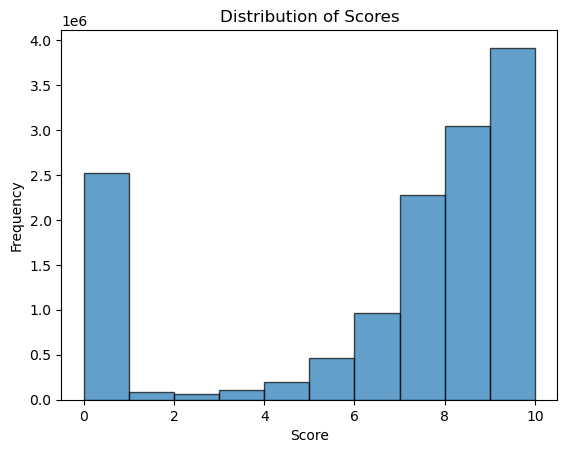

In [56]:
# having a look at the distribution of the reviews made by users 
plt.hist(reviews['score'], bins=range(11), alpha=0.7, edgecolor='black')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

In [57]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13636473 entries, 0 to 14108061
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   score      float64
 1   sid        int64  
 2   uid        int64  
 3   ep_seen    int64  
 4   ep_total   int64  
 5   completed  bool   
dtypes: bool(1), float64(1), int64(4)
memory usage: 637.2 MB


In [58]:
# As the dataset with our drama information only includes a small percentage of the dramas need to 
# filter the 'reviews' DataFrame to include only those rows where 'sid' matches with the 'sid' in 'df'
filtered_reviews = reviews[reviews['sid'].isin(df['sid'])]

In [59]:
filtered_reviews.info()
# wow 5,257,498 reviews removed. but still have a bunch left so yay

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8378975 entries, 0 to 14108060
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   score      float64
 1   sid        int64  
 2   uid        int64  
 3   ep_seen    int64  
 4   ep_total   int64  
 5   completed  bool   
dtypes: bool(1), float64(1), int64(4)
memory usage: 391.5 MB


In [60]:
# now lets look at users
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78209 entries, 0 to 84606
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   username      78209 non-null  object        
 1   gender        78209 non-null  category      
 2   join_date     78207 non-null  datetime64[ns]
 3   last_online   78206 non-null  datetime64[ns]
 4   ndropped      78209 non-null  int64         
 5   ncompleted    78209 non-null  int64         
 6   uid           78209 non-null  int64         
 7   review_count  78209 non-null  int32         
dtypes: category(1), datetime64[ns](2), int32(1), int64(3), object(1)
memory usage: 4.5+ MB


In [61]:
# as there may be users that have never rated, we should remove these. 
# filtering out users dataset with users that have made at least 1 review. 
unique_user_ids = filtered_reviews['uid'].unique()
filtered_users = users[users['uid'].isin(unique_user_ids)]
filtered_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77538 entries, 0 to 84606
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   username      77538 non-null  object        
 1   gender        77538 non-null  category      
 2   join_date     77536 non-null  datetime64[ns]
 3   last_online   77535 non-null  datetime64[ns]
 4   ndropped      77538 non-null  int64         
 5   ncompleted    77538 non-null  int64         
 6   uid           77538 non-null  int64         
 7   review_count  77538 non-null  int32         
dtypes: category(1), datetime64[ns](2), int32(1), int64(3), object(1)
memory usage: 4.5+ MB


In [62]:
# great. only 671 were removed 

In [63]:
#updating the review count by each user. because there are some outliers here 
# updating review count column 
# Count the number of reviews for each user
review_counts = filtered_reviews['uid'].value_counts().reset_index()
review_counts.columns = ['uid', 'new_review_count']

In [64]:
filtered_users = pd.merge(filtered_users, review_counts, on='uid', how='left')
filtered_users['review_count'] = filtered_users['new_review_count']
filtered_users.drop('new_review_count', axis=1, inplace=True)
filtered_users['review_count'].fillna(0, inplace=True)


In [65]:
## finding the bots who ONLY rated 0 or ONLY rated 10 and filtering them out 
# Group by 'uid' and find the min and max score for each user
grouped_reviews = filtered_reviews.groupby('uid')['score'].agg(['min', 'max', 'count']).reset_index()


In [66]:
# Identify users who have ONLY rated 0's more than 30 times
potential_zero_bots = grouped_reviews[(grouped_reviews['min'] == 0) & 
                                      (grouped_reviews['max'] == 0) & 
                                      (grouped_reviews['count'] > 30)]

# Identify users who have ONLY rated 10's more than 50 times
potential_ten_bots = grouped_reviews[(grouped_reviews['min'] == 10) & 
                                     (grouped_reviews['max'] == 10) & 
                                     (grouped_reviews['count'] > 50)]


In [67]:
potential_zero_bots

,uid,min,max,count
72,83,0.0,0.0,255
110,122,0.0,0.0,123
178,200,0.0,0.0,34
230,260,0.0,0.0,38
512,581,0.0,0.0,45
...,...,...,...,...
76444,83424,0.0,0.0,31
76895,83914,0.0,0.0,90
77033,84066,0.0,0.0,36
77318,84371,0.0,0.0,42


In [68]:
potential_ten_bots

,uid,min,max,count
1343,1558,10.0,10.0,73
1978,2315,10.0,10.0,250
2577,3007,10.0,10.0,128
4107,4695,10.0,10.0,1959
5039,5687,10.0,10.0,184
...,...,...,...,...
72927,79622,10.0,10.0,57
76383,83359,10.0,10.0,65
76445,83425,10.0,10.0,51
76535,83528,10.0,10.0,138


In [69]:
# Combine the lists of user IDs from potential_zero_bots and potential_ten_bots
bot_user_ids = potential_zero_bots['uid'].tolist() + potential_ten_bots['uid'].tolist()

# Remove these users from filtered_users
filtered_users = filtered_users[~filtered_users['uid'].isin(bot_user_ids)]

# Remove reviews made by these users from filtered_reviews
filtered_reviews = filtered_reviews[~filtered_reviews['uid'].isin(bot_user_ids)]

In [70]:
filtered_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8330711 entries, 0 to 14108060
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   score      float64
 1   sid        int64  
 2   uid        int64  
 3   ep_seen    int64  
 4   ep_total   int64  
 5   completed  bool   
dtypes: bool(1), float64(1), int64(4)
memory usage: 389.3 MB


In [71]:
# now to get rid of the reviews from people that have reviewed very little

In [72]:
# Count unique dramas reviewed by each user
user_review_counts = filtered_reviews.groupby('uid')['sid'].nunique()

In [73]:
# Identify users who have reviewed fewer than 20 dramas
users_with_few_reviews = user_review_counts[user_review_counts < 200].index

In [74]:
# Filter out reviews from users with fewer than 20 reviews
filtered_reviews = filtered_reviews[~filtered_reviews['uid'].isin(users_with_few_reviews)]


Text(0, 0.5, 'Frequency')

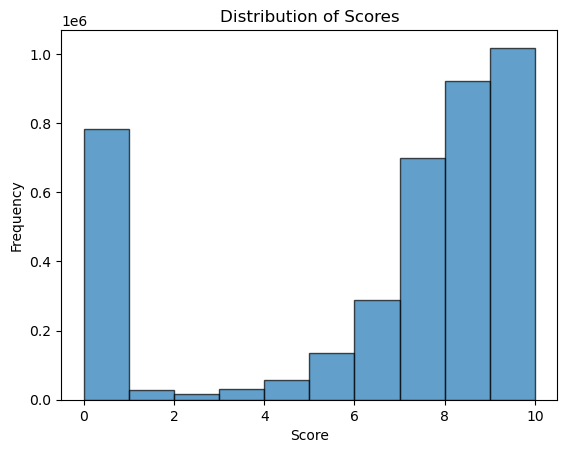

In [75]:
# lets see the rating distribution of the new filtered df 
plt.hist(filtered_reviews['score'], bins=range(11), alpha=0.7, edgecolor='black')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

In [76]:
# should I get rid of the 0 score.... thats a lot of values... 
# if there is too much variance in the ratings this may make the recommendations hard to estimate... 
# will leave 0's for now. in future it might be interesting to remove the scores below 5 for better recommendations
filtered_reviews['score'].value_counts()

0.0     783704
8.0     551318
9.0     415181
10.0    397697
8.5     369336
7.0     362767
7.5     336492
9.5     205429
6.0     156700
6.5     131993
5.0      82981
5.5      53109
4.0      35954
4.5      22545
1.0      21678
3.0      19342
2.0      12545
3.5      12364
2.5       5396
1.5       5177
0.5         95
Name: score, dtype: int64

In [77]:
# lets see which users voted a MAJORITY of 0's instead of JUST 0's
# Group by 'uid' and count total reviews and how many of them are 0-score reviews
grouped_reviews = filtered_reviews.groupby('uid').agg(total_reviews=('score', 'count'),
                                                      zero_reviews=('score', lambda x: (x == 0).sum())).reset_index()
# Calculate the proportion of 0-score reviews
grouped_reviews['zero_score_proportion'] = grouped_reviews['zero_reviews'] / grouped_reviews['total_reviews']
# Define a threshold for majority (e.g., 0.5 for 50%)
majority_threshold = 0.80

# Identify users who have majority of their ratings as 0
potential_majority_zero_bots = grouped_reviews[grouped_reviews['zero_score_proportion'] > majority_threshold]

In [78]:
# Get the list of user IDs from potential_majority_zero_bots
majority_zero_bot_user_ids = potential_majority_zero_bots['uid'].tolist()

# Remove these users from filtered_users
filtered_users = filtered_users[~filtered_users['uid'].isin(majority_zero_bot_user_ids)]

# Remove reviews made by these users from filtered_reviews
filtered_reviews = filtered_reviews[~filtered_reviews['uid'].isin(majority_zero_bot_user_ids)]


In [79]:
filtered_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630660 entries, 286 to 14107371
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   score      float64
 1   sid        int64  
 2   uid        int64  
 3   ep_seen    int64  
 4   ep_total   int64  
 5   completed  bool   
dtypes: bool(1), float64(1), int64(4)
memory usage: 169.7 MB


In [80]:
filtered_reviews['score'].value_counts()

8.0     548636
0.0     458103
9.0     411206
10.0    389152
8.5     367225
7.0     361292
7.5     335228
9.5     202819
6.0     156047
6.5     131592
5.0      82565
5.5      52861
4.0      35777
4.5      22415
1.0      21242
3.0      19208
2.0      12465
3.5      12267
2.5       5356
1.5       5116
0.5         88
Name: score, dtype: int64

In [81]:
# do i want to see the same for majority 10's? 

# Group by 'uid' and count total reviews and how many of them are 10-score reviews
grouped_reviews = filtered_reviews.groupby('uid').agg(total_reviews=('score', 'count'),
                                                      ten_reviews=('score', lambda x: (x == 10).sum())).reset_index()
# Calculate the proportion of 10-score reviews
grouped_reviews['ten_score_proportion'] = grouped_reviews['ten_reviews'] / grouped_reviews['total_reviews']
# Define a threshold for majority (e.g., 0.5 for 50%)
majority_threshold = 0.90

# Identify users who have majority of their ratings as 10
potential_majority_ten_bots = grouped_reviews[grouped_reviews['ten_score_proportion'] > majority_threshold]
potential_majority_ten_bots

,uid,total_reviews,ten_reviews,ten_score_proportion
23,372,438,434,0.990868
26,427,227,225,0.991189
40,755,244,242,0.991803
46,874,248,226,0.911290
67,1290,506,505,0.998024
...,...,...,...,...
9704,74927,221,218,0.986425
10071,77656,244,241,0.987705
10257,79126,436,433,0.993119
10505,81002,267,261,0.977528


In [82]:
# Get the list of user IDs from potential_majority_zero_bots
majority_ten_bot_user_ids = potential_majority_ten_bots['uid'].tolist()

# Remove these users from filtered_users
filtered_users = filtered_users[~filtered_users['uid'].isin(majority_ten_bot_user_ids)]

# Remove reviews made by these users from filtered_reviews
filtered_reviews = filtered_reviews[~filtered_reviews['uid'].isin(majority_ten_bot_user_ids)]

In [83]:
filtered_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3604464 entries, 286 to 14107371
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   score      float64
 1   sid        int64  
 2   uid        int64  
 3   ep_seen    int64  
 4   ep_total   int64  
 5   completed  bool   
dtypes: bool(1), float64(1), int64(4)
memory usage: 168.4 MB


In [84]:
filtered_reviews['score'].value_counts()

8.0     548569
0.0     457811
9.0     411055
8.5     367166
10.0    363981
7.0     361248
7.5     335196
9.5     202535
6.0     156032
6.5     131587
5.0      82525
5.5      52848
4.0      35774
4.5      22414
1.0      21232
3.0      19207
2.0      12465
3.5      12265
2.5       5353
1.5       5115
0.5         86
Name: score, dtype: int64

Text(0, 0.5, 'Frequency')

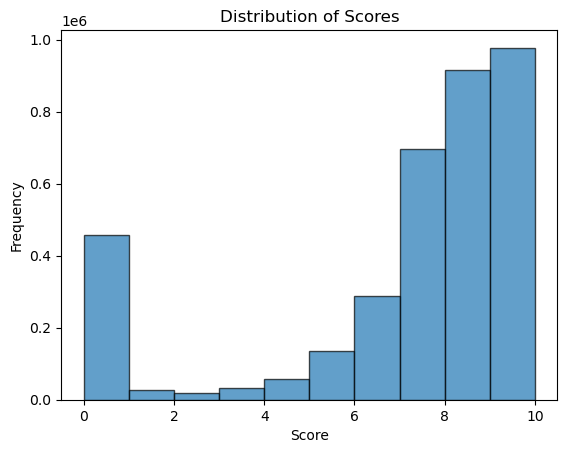

In [85]:
# lets see the rating distribution of the new filtered df 
plt.hist(filtered_reviews['score'], bins=range(11), alpha=0.7, edgecolor='black')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

In [86]:
# much better than the last one 
# now i should see how many ratings each drama has been given. update the num_ratings to the orig df. 
#need to see if there are any tv dramas in my original df dataframe that have not been rated or have been rated only once

In [87]:
# Count the number of reviews for each 'sid' in 'filtered_reviews'
review_counts = filtered_reviews['sid'].value_counts().reset_index()
review_counts.columns = ['sid', 'num_reviews']

In [88]:
# updating review count column 
# counting number of reviews for each user
df_reviews = pd.merge(df, review_counts, on='sid', how='left')
#df_reviews['num_reviews'] = filtered_users['num_reviews']
#df_reviews.drop('num_reviews', axis=1, inplace=True)
df_reviews['num_reviews'].fillna(0, inplace=True)

In [89]:
df_reviews

,Name,category,country,num_episodes,aired,watchers,rating,num_raters,cast_names,genre_names,tag_names,synopsis,url,sid,num_reviews
0,tunnel,Drama,South Korea,16.0,2017,32651,8.7,14787,"Choi Jin Hyuk,Yoon Hyun Min,Lee Yoo Young,Jo H...","Thriller,Mystery,Sci-Fi,Fantasy","Time Travel,Murder,Criminal Profiler,Serial K...","In 1986, Park Gwang Ho works as an excellent a...",https://i.mydramalist.com/JkryYc.jpg?v=1,15673.0,4130.0
1,twenty-five twenty-one,Drama,South Korea,16.0,2022,16043,8.8,2119,"Kim Tae Ri,Nam Joo Hyuk,Bona,Choi Hyun Wook,Le...","Romance,Life,Youth,Drama","Athlete,Fencing,1990s,Coming Of Age,Bold Fema...",The story is set in 1998 and tells the stories...,https://i.mydramalist.com/ROOPo_4c.jpg?v=1,40541.0,3731.0
2,dr. romantic season 2,Drama,South Korea,16.0,2020,31855,8.7,15880,"Han Seok Kyu,Ahn Hyo Seop,Lee Sung Kyung,Kim J...","Romance,Drama,Medical,Melodrama","Hospital,Smart Male Lead,Character Developmen...","A real doctor story set in a small, humble h...",https://i.mydramalist.com/Rr7DEc.jpg?v=1,26981.0,4129.0
3,move to heaven,Drama,South Korea,10.0,2021,40962,9.2,20399,"Lee Je Hoon,Tang Jun Sang,Hong Seung Hee,Jung ...","Life,Drama,Family","Autism,Uncle-Nephew Relationship,Death,Savant...",Geu Roo is a young autistic man. He works for ...,https://i.mydramalist.com/Rle36_4c.jpg?v=1,29419.0,3911.0
4,the king’s avatar,Drama,China,40.0,2019,24236,8.6,8734,"Yang Yang,Jiang Shu Ying,Lai Yu Meng,Daisy Li,...","Action,Friendship,Youth,Sports","Online Gaming,Strong Friendship,Smart Male Le...","In the multiplayer online game Glory, Ye Xiu i...",https://i.mydramalist.com/2O0xEc.jpg?v=1,17517.0,2029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4276,precious family,Drama,South Korea,68.0,2005,216,7.9,25,"Kim Hae Sook,Song Jae Ho,Kim Hee Ae,Heo Joon H...","Romance,Drama,Family","Unhealthy Mains' Relationship,Married Couple,...",The drama shows how members of a good-natured ...,https://i.mydramalist.com/MgwWPc.jpg?v=1,5453.0,22.0
4277,kungfu cop,Drama,China,45.0,2021,118,7.9,18,"Joe Xu,Mou Xing,Xu Hong Jie,Vicki He,Xia Hou B...","Action,Military,Crime","Special Task Force,Police Department,Psycholo...",A small response team under the leadership of ...,https://i.mydramalist.com/pre3Q_4c.jpg?v=1,38087.0,11.0
4278,the confidence,Drama,China,40.0,2021,853,7.9,86,"Elvira Cai,Liu Kai,Peng Guan Ying,Yue Yang,Li ...",Thriller,"Hidden Identity,Criminal,Adapted From A Novel...",Talented economics lecturer Ke Ying finds hims...,https://i.mydramalist.com/2OBNRc.jpg?v=1,24736.0,93.0
4279,here comes fortune star,Drama,Taiwan,60.0,2021,197,7.9,22,"Lego Lee,Lee Yi Jie,David Chiu,Liang Shu Han,S...","Adventure,Romance,Life,Fantasy","Mortal World,Unfortunate Female Lead,Deity,Re...",God of wealth Zhao Zimo was demoted to the mor...,https://i.mydramalist.com/RgJ0E_4c.jpg?v=1,37432.0,13.0


In [90]:
sorted_ratings = df_reviews.sort_values(by='num_reviews', ascending=True)
sorted_ratings.head(50)

,Name,category,country,num_episodes,aired,watchers,rating,num_raters,cast_names,genre_names,tag_names,synopsis,url,sid,num_reviews
3862,forever young at heart,Drama,Hong Kong,10.0,2022,51,7.9,4,"Gigi Yim,Chantel Yiu,Yumi Chung,Archie Sin,JW,...","Friendship,School,Youth","Musical,Multiple Mains,Student,Mental Health",High school is the most youthful and passionat...,https://i.mydramalist.com/4QQNk_4c.jpg?v=1,44007.0,0.0
4149,batten robomaru,Drama,Japan,51.0,1983,22,9.1,3,"Soga Machiko,Ishii Kenichi,Ichikawa Isamu,Ogaw...","Tokusatsu,Comedy",,The second entry in the Toei Fushigi Comedy Se...,https://i.mydramalist.com/vRVXec.jpg?v=1,31004.0,0.0
2835,balangaw,Drama,Philippines,5.0,2020,129,8.6,3,"Joselito Altarejos,Miss Mela Habijan,Karen Toy...","Romance,Drama","Gay Romance,COVID-19,Lockdown,LGBTQ+,Miniseri...",Eight colorful and diverse people bonded toget...,https://i.mydramalist.com/1zZDd_4c.jpg?v=1,33659.0,0.0
4151,hamidashi keiji jonetsu kei season 6,Drama,Japan,24.0,2002,21,9.1,10,"Shibata Kyohei,Fubuki Jun,Kamiki Ryunosuke,Yab...","Mystery,Comedy,Romance,Family","Investigation,Detective,Drama","Hyogo Yakami and Reiko Negishi, both police of...",https://i.mydramalist.com/XRVWn_4c.jpg?v=1,22624.0,0.0
2933,love songs love series: seb tid kwam jeb puad,Drama,Thailand,4.0,2018,111,8.4,3,"Chimon Wachirawit Ruangwiwat,Marc Thanat Ratta...","Romance,Drama",Miniseries,A drama about teen love and the pains that com...,https://i.mydramalist.com/RP46xc.jpg?v=1,22078.0,0.0
3165,genesis,Drama,Philippines,55.0,2013,5,8.2,3,"Dingdong Dantes,Rhian Ramos,Lorna Tolentino,TJ...","Romance,Drama,Sci-Fi",,Genesis is a Philippine television drama scien...,https://i.mydramalist.com/2kXLP_4c.jpg?v=1,35409.0,0.0
2951,the kidnappers,Drama,China,24.0,2019,106,8.4,3,"Li Li Ren,Jia Jing Hui,Li Ning,Li Ru Ge,Zhao Y...","Action,Thriller,Mystery,Drama","Doctor Male Lead,Motives,Hematology,Death,Age...","After being released from prison, a mysterious...",https://i.mydramalist.com/lJP3bc.jpg?v=1,24940.0,0.0
4159,ruk paed pun kao,Drama,Thailand,90.0,2005,19,8.7,3,"Bee Namthip Jongrachatawiboon,Captain Phutanat...",Sitcom,,Living in 8009 Bangkok apartment come few youn...,https://i.mydramalist.com/ROrzr_4c.jpg?v=1,17932.0,0.0
2956,the elder brother and elder sister's good age,Drama,China,56.0,2019,29,8.4,3,"Wang Ya Jie,Wang Ting,Shi Guang Hui,Kong Ying ...","Romance,Drama,Family",,A sent-down youth who returns home after livin...,https://i.mydramalist.com/6Vlm2_4c.jpg?v=1,27084.0,0.0
4164,paano ang pasko?,Drama,Philippines,30.0,2021,30,8.6,4,"Elijah Canlas,Julia Clarete,Beauty Gonzalez,Ma...","Drama,Family",,This special drama series revolves around a fa...,https://i.mydramalist.com/EZx8O_4c.jpg?v=1,37519.0,0.0


In [91]:
## looks like there are some dramas with no ratings. lets remove these 
sids_with_few_reviews = set(df['sid']) - set(review_counts[review_counts['num_reviews'] > 1]['sid'])

dramas_with_few_or_no_reviews = df[df['sid'].isin(sids_with_few_reviews)]

In [92]:
# lets see if we can only grab dramas with over a certain amount of ratings
# because if i do recommender with dramas that have no ratings it'll give me errors
df_test = df_reviews[df_reviews['num_reviews'] >20]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3497 entries, 0 to 4278
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          3497 non-null   object 
 1   category      3497 non-null   object 
 2   country       3497 non-null   object 
 3   num_episodes  3497 non-null   float64
 4   aired         3497 non-null   int64  
 5   watchers      3497 non-null   int64  
 6   rating        3497 non-null   float64
 7   num_raters    3497 non-null   int64  
 8   cast_names    3497 non-null   object 
 9   genre_names   3497 non-null   object 
 10  tag_names     3497 non-null   object 
 11  synopsis      3497 non-null   object 
 12  url           3497 non-null   object 
 13  sid           3497 non-null   float64
 14  num_reviews   3497 non-null   float64
dtypes: float64(4), int64(3), object(8)
memory usage: 437.1+ KB


In [93]:
# judging from the above, it shouldnt remove too many dramas, so lets make it so it has to be > 50 ratings
df_use = df_reviews[df_reviews['num_reviews'] >50]
df_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3346 entries, 0 to 4278
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          3346 non-null   object 
 1   category      3346 non-null   object 
 2   country       3346 non-null   object 
 3   num_episodes  3346 non-null   float64
 4   aired         3346 non-null   int64  
 5   watchers      3346 non-null   int64  
 6   rating        3346 non-null   float64
 7   num_raters    3346 non-null   int64  
 8   cast_names    3346 non-null   object 
 9   genre_names   3346 non-null   object 
 10  tag_names     3346 non-null   object 
 11  synopsis      3346 non-null   object 
 12  url           3346 non-null   object 
 13  sid           3346 non-null   float64
 14  num_reviews   3346 non-null   float64
dtypes: float64(4), int64(3), object(8)
memory usage: 418.2+ KB


In [94]:
df_use.columns

Index(['Name', 'category', 'country', 'num_episodes', 'aired', 'watchers',
       'rating', 'num_raters', 'cast_names', 'genre_names', 'tag_names',
       'synopsis', 'url', 'sid', 'num_reviews'],
      dtype='object')

In [95]:
filtered_reviews

,score,sid,uid,ep_seen,ep_total,completed
286,0.0,33803,6389,12,30,False
287,0.0,30235,6389,3,13,False
288,0.0,26435,6389,10,48,False
289,0.0,24230,6389,12,32,False
290,0.0,27320,6389,5,34,False
...,...,...,...,...,...,...
14107367,8.5,8424,80379,20,20,True
14107368,8.5,2954,80379,16,16,True
14107369,9.0,21675,80379,32,32,True
14107370,9.0,36553,80379,12,12,True


In [96]:
## now need to remove the reviews of the sid that i just removed from having too little reviews
# Get the list of remaining sids in df_use
remaining_sids = df_use['sid'].unique()
# Filter the reviews dataset
filtered_reviews = filtered_reviews[filtered_reviews['sid'].isin(remaining_sids)]

In [97]:
filtered_reviews

,score,sid,uid,ep_seen,ep_total,completed
286,0.0,33803,6389,12,30,False
287,0.0,30235,6389,3,13,False
288,0.0,26435,6389,10,48,False
289,0.0,24230,6389,12,32,False
290,0.0,27320,6389,5,34,False
...,...,...,...,...,...,...
14107367,8.5,8424,80379,20,20,True
14107368,8.5,2954,80379,16,16,True
14107369,9.0,21675,80379,32,32,True
14107370,9.0,36553,80379,12,12,True


In [98]:
# Great! 3.5 million ratings to use for recommender should be sufficient

In [99]:
# making a df with just the sid and Name for indexing and tagging purposes
df_titles = df_use[['sid', 'Name']]
df_titles['sid'] = df_titles['sid'].astype(int)
df_titles.set_index('sid', inplace=True)
df_titles.head()

C:\Users\kelli\AppData\Local\Temp\ipykernel_27928\3190968903.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name
sid,
15673,tunnel
40541,twenty-five twenty-one
26981,dr. romantic season 2
29419,move to heaven
17517,the king’s avatar


In [100]:
# #save these datasets
# df_titles.to_csv("df_titles.csv")
# df_use.to_csv("df_use.csv")

In [117]:
# lets remove the unwanted columns in filtered_reviews df and only leave User, Rating, Drama to make into matrix
reviews = filtered_reviews[['uid', 'score', 'sid']]
reviews.rename(columns={'uid': 'User', 'score': 'Rating', 'sid': 'Drama'}, inplace=True)
#reviews.head(30)
reviews.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3595051 entries, 286 to 14107371
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   User    int64  
 1   Rating  float64
 2   Drama   int64  
dtypes: float64(1), int64(2)
memory usage: 109.7 MB


C:\Users\kelli\AppData\Local\Temp\ipykernel_26860\1216194010.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [120]:
# # saving file
# from fastparquet import write
# write('reviews.parq', reviews)

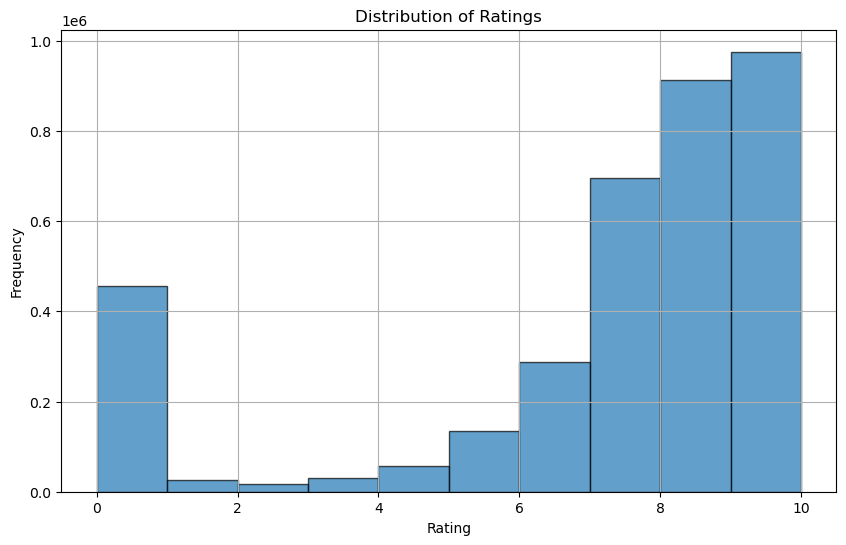

In [118]:
# plotting the distribution of ratings in my reviews dataset for the final time to get a clear distribution
plt.figure(figsize=(10, 6))
plt.hist(reviews['Rating'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Starting the training and recomm 

In [51]:
# over to TrainingRecommenders notebook